In [1]:
%pip install -U torchvision
import torch
from tqdm.auto import tqdm, trange
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 21.0 MB 193 kB/s            
     |████████████████████████████████| 750.6 MB 8.6 kB/s             ��████████████████▉      | 606.2 MB 61.5 MB/s eta 0:00:03
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.5.3 requires torch<1.11,>=1.7.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.1 requires torch<1.11.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.1 requires torchvision<0.12.0,>=0.8.1, but you have torchvision 0.12.0 which is incompatible.
Note: you ma

In [2]:
class tanh_discr(torch.autograd.Function):
    '''
    Implementation of discretized 𝑡𝑎𝑛ℎ activation functions.
    Returns value from -1 to +1
    In backward pass behaves as ordinary tanh

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Parameters:
        - n - discretization parameter

    References:
        - See related paper:
        https://arxiv.org/pdf/2105.01768.pdf

    Examples:
        >>> x = torch.randn(256)
        >>> x = tanh_discr.apply(x, 256)
    '''
    @staticmethod
    def forward(ctx, x, n=2):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        th = torch.tanh(x)
        ctx.save_for_backward(th)
        _n = (n-1)/2
        return torch.round(_n + _n * th) / _n - 1
    
    @staticmethod
    def backward(ctx, grad_output):
        th, = ctx.saved_tensors
        return (1 - th ** 2) * grad_output, None

class PreEncoder(nn.Module):
    def __init__(self, num_layers=6, num_channels=128, kernel_size=5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(3, num_channels, kernel_size, padding='same')])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size, padding='same'))

    def forward(self, x):
        for conv in self.convs:
            x = torch.relu(conv(x))
        return x

class DownDiscretizationEncoder(nn.Module):
    def __init__(self, kernel_size=5, input_channels = 128):
        super().__init__()
        num_layers=8
        self.convs = nn.ModuleList([nn.Conv2d(input_channels, 1, kernel_size, padding='same')])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(1, 1, kernel_size, padding='same'))
        
    def forward(self, x):
        for removed_bits, conv in enumerate(self.convs):
            x = tanh_discr.apply(conv(x), 2 ** (8 - removed_bits))
        return x

class Decoder(nn.Module):
    def __init__(self, num_layers=2, num_channels=128, kernel_size=5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(1, num_channels, kernel_size, padding='same')])
        for i in range(num_layers - 2):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size, padding='same'))
        self.convs.append(nn.Conv2d(num_channels, 3, kernel_size, padding='same'))

    def forward(self, x):
        for conv in self.convs[:-1]:
            x = F.relu(conv(x))
        x = torch.tanh(self.convs[-1](x))
        return x

class TexturesModel(nn.Module):
    def __init__(self, num_layers=6, num_channels=128, kernel_size=5, alpha=0.1, beta=0.1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.pre_encoder = PreEncoder(num_layers, num_channels, kernel_size=kernel_size)
        self.dde = DownDiscretizationEncoder(input_channels=num_channels, kernel_size=kernel_size)
        self.decoder = Decoder(num_layers, num_channels, kernel_size=kernel_size)

    def forward(self, x):
        x = self.pre_encoder(x)
        x = self.dde(x)
        return x

    def encode_decode(self, x):
        x = self.pre_encoder(x)
        x = self.dde(x)
        x = self.decoder(x)
        return x

    def compute_loss(self, x):
        stride = 8
        encoded = self.dde(self.pre_encoder(x))
        decoded = self.decoder(encoded)
        restoration_loss = F.mse_loss(x, decoded)
        input_brightness = F.avg_pool2d(x.mean(axis=1, keepdims=True), 8, stride=stride).ravel()
        input_brightness_diffs = input_brightness - input_brightness.T
        encoded_brghtness = F.avg_pool2d(encoded, 8, stride=stride).ravel()
        encoded_brghtness_diffs = encoded_brghtness - encoded_brghtness.T
        intensicy_loss = (torch.tanh(input_brightness_diffs)- torch.tanh(encoded_brghtness_diffs) ).abs().mean()
        color_shift = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        color_continuity_loss = (encoded- self.dde(self.pre_encoder(color_shift(x)))).abs().mean()

        total_loss = restoration_loss + self.alpha * intensicy_loss + self.beta * color_continuity_loss
        return total_loss



In [3]:
import torchvision.transforms as transforms
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

stl_data = torchvision.datasets.STL10(root='/stl_data', transform=transform, split='unlabeled', download=True)
stl_loader = torch.utils.data.DataLoader(stl_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# celeba_data = torchvision.datasets.CelebA(root='/celeba_data', split='train', transform=transform, download=True)
# celeba_loader = torch.utils.data.DataLoader(celeba_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# cars_data = torchvision.datasets.StanfordCars(root='/cars_data', transform=transform, download=True)
# cars_loader = torch.utils.data.DataLoader(cars_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# imagenet_data = torchvision.datasets.ImageNet('./imagenet_data', download=True, transform=transforms.ToTensor(), split='val')
# imagenet_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /stl_data/stl10_binary.tar.gz to /stl_data


In [4]:
import torch.optim as optim

net = TexturesModel().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6250 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)


[1] loss: 0.11786279827356339


  0%|          | 0/6250 [00:00<?, ?it/s]

[2] loss: 0.08811720460653305


  0%|          | 0/6250 [00:00<?, ?it/s]

[3] loss: 0.0830163061618805


  0%|          | 0/6250 [00:00<?, ?it/s]

[4] loss: 0.07936785370111465
Finished Training


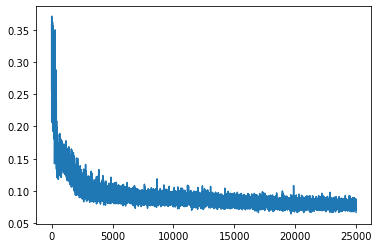

In [5]:
loader = stl_loader
running_loss = 0.0
losses = []
for epoch in trange(4):  # loop over the dataset multiple times
    
    for data in tqdm(loader, leave=False, total=len(loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = net.compute_loss(inputs) 
        loss.backward()
        optimizer.step()

        running_loss += loss
        losses.append(loss.cpu().detach())
    # print statistics
    tqdm.write(f'[{epoch + 1}] loss: {running_loss/len(stl_loader)}')
    running_loss = 0.0

plt.plot(losses)

print('Finished Training')

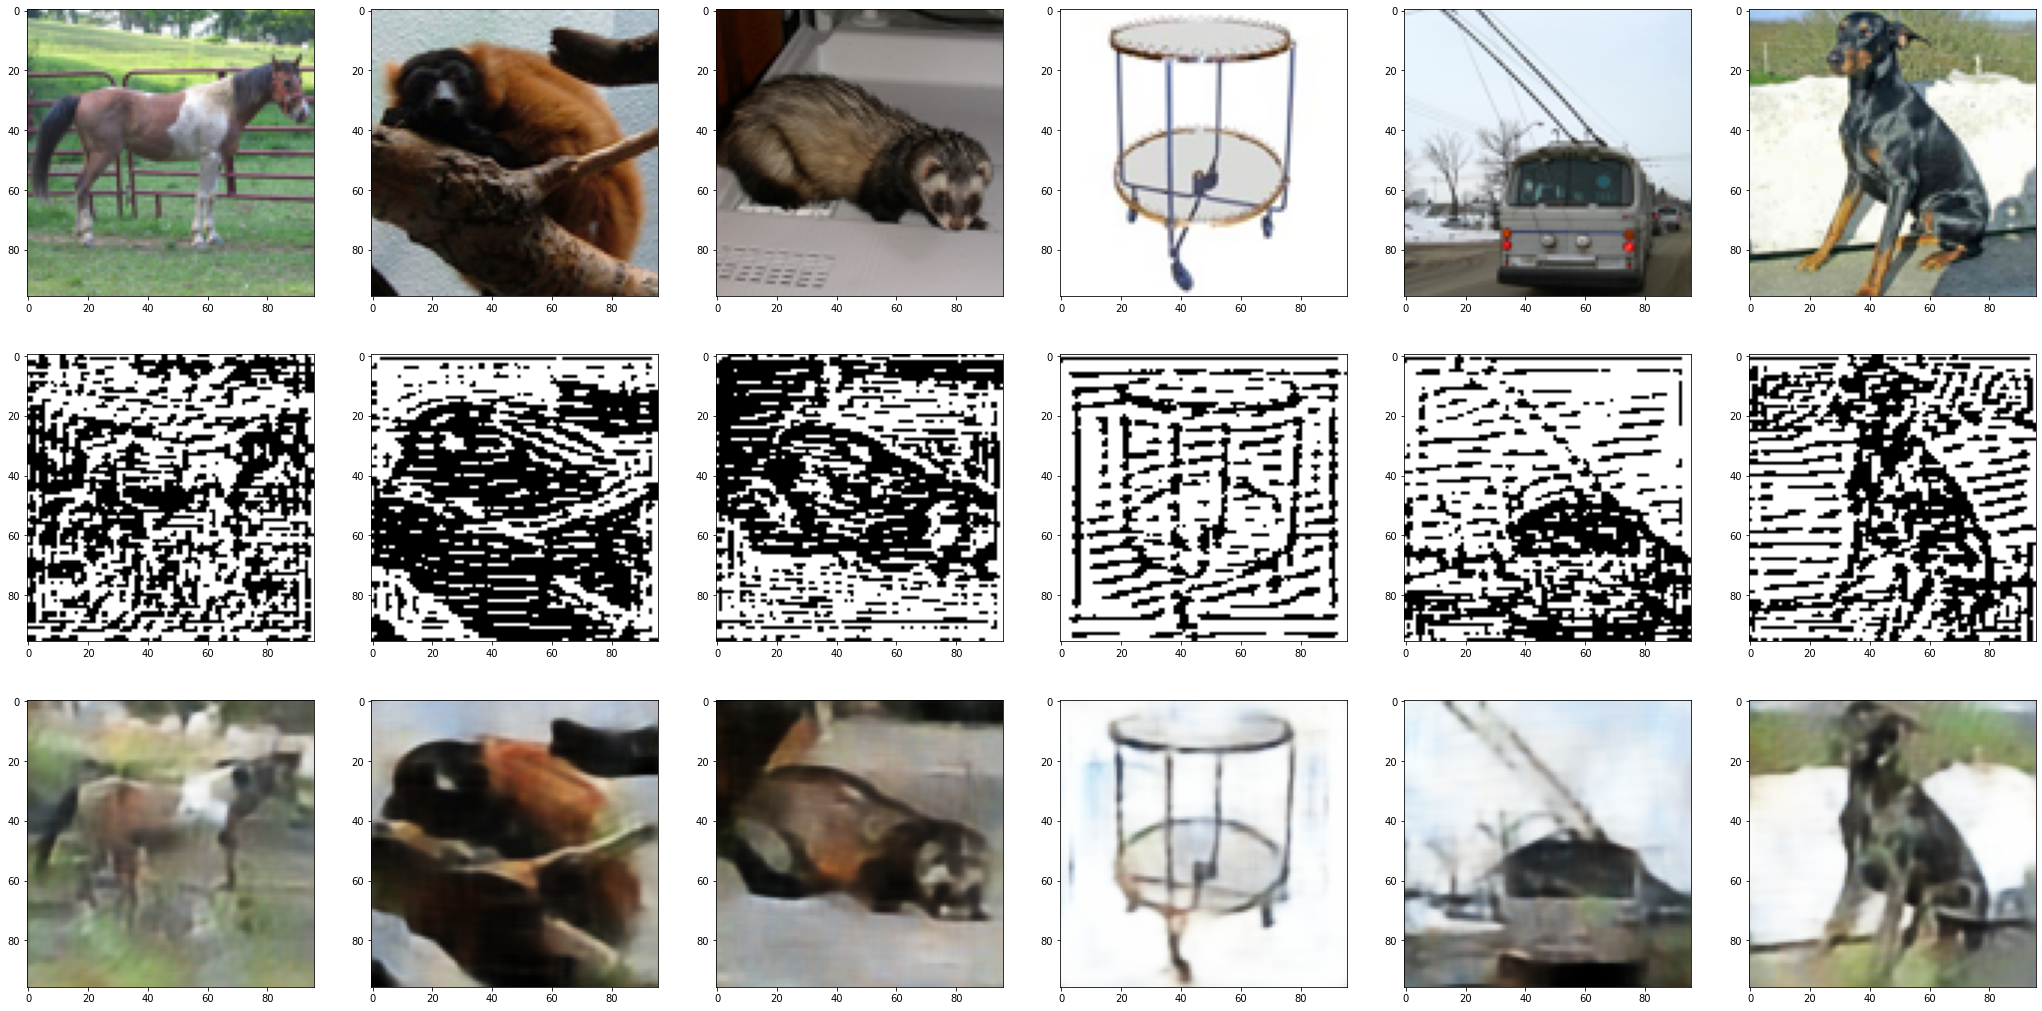

In [8]:
for loader in [stl_loader]:
    train_features, train_labels = next(iter(loader))
    compressed = net(train_features.to(device))
    decoded = net.encode_decode(train_features.to(device))
    num = min(batch_size, 6)
    fig, axs = plt.subplots(3, num, figsize=(num * 6, 18))
    for i in range(num):
        img = train_features[i].squeeze()
        axs[0, i].imshow(np.moveaxis(img.numpy()/2+0.5, 0, -1))
        axs[1, i].imshow(np.squeeze(compressed[i].cpu().detach().numpy(), 0) * 255, cmap='gray')
        axs[2, i].imshow(np.moveaxis(decoded[i].cpu().detach().numpy()/2+0.5, 0, -1), cmap='gray')
    plt.show()

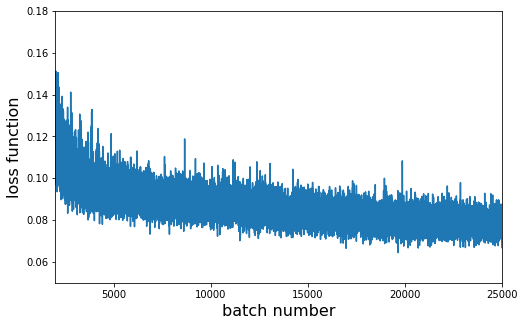

In [17]:
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.xlabel("batch number",fontsize=16)
plt.ylabel("loss function",fontsize=16)
plt.xlim(2000,25000)
plt.ylim(0.05,0.18)
plt.show()


In [19]:
torch.save(net, './model.torch')